<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Faster_optimizers_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks

In a past article we introduced artificial neural networks and trained our first deep neural networks. But they were shallow nets, with just a few hidden layers. What if you need to tackle a complex problem, such as detecting hundreds of types of objects in high-resolution images? You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep DNN isn’t a walk in the park. Here are some of the problems you could run into:

- You may be faced with the tricky *vanishing gradients* problem or the related *exploding gradients* problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- You might not have enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

In this notebook we will discuss various optimizers that can speed up training large models tremendously.

## Faster optimizers

Training a very large deep neural network can be painfully slow. There are diferent ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using [Batch Normalization](https://github.com/victorviro/Deep_learning_python/blob/master/Vanishing_Exploding_gradients_problem_DNNs.ipynb), and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular [Gradient Descent optimizer](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_gradient_descent_algorithm.ipynb). In this section we will present the most popular algorithms: momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.



### Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind momentum optimization, proposed by Boris Polyak in 1964. In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that Gradient Descent updates the weights $\boldsymbol{\theta}$ by directly subtracting the gradient of the cost function $J(\boldsymbol{\theta})$ with regard to the weights $(\nabla_{\theta}J(\boldsymbol{\theta}))$ multiplied by the learning rate $\eta$. The equation is: 
$$\boldsymbol{\theta}_t \leftarrow  \boldsymbol{\theta}_{t-1} - \eta \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})$$

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the *momentum vector* $\boldsymbol{m}$ (multiplied by the learning rate $\eta$), and it updates the weights by adding this momentum vector (see equation). In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

\begin{cases}
\boldsymbol{m}_t \leftarrow  \beta\boldsymbol{m}_{t-1} - \eta \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})\\\\
\boldsymbol{\theta}_t \leftarrow  \boldsymbol{\theta}_{t-1} + \boldsymbol{m}_t
\end{cases}

**Note**: Some implementations exchange the signs in the equations.

Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way (until it reaches its terminal velocity if there is friction or air resistance, i.e. $\beta < 1$). The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.

You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate $\eta$ multiplied by $\frac{1}{1-\beta}$ (ignoring the sign). For example, if $\beta = 0.9$, then the terminal velocity is equal to $10$ times the gradient times the learning rate, so momentum optimization ends up going $10$ times faster than Gradient Descent! This allows momentum optimization to escape from plateaus much faster than Gradient Descent. We saw in ([notebook gradient descent](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_gradient_descent_algorithm.ipynb)) that when the inputs have very different scales, the cost function will look like an elongated bowl (see Figure 4-7). Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. In contrast, momentum optimization will roll down the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so using momentum optimization helps a lot. It can also help roll past local optima.

![texto alternativo](https://i.ibb.co/Qkr1DHz/sgd-vd-momentum.png)

**Note**: Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it’s good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.



Implementing momentum optimization in Keras is simple: just use the `SGD` optimizer and set its `momentum` hyperparameter.

In [17]:
import keras

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of $0.9$ usually works well in practice and almost always goes faster than regular Gradient Descent.

### Nesterov Accelerated Gradient

However, a ball that rolls down a hill, blindly following the slope, is highly unsatisfactory. We'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again.

One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization. The **Nesterov Accelerated Gradient** (NAG) method, also known as **Nesterov momentum optimization**, measures the gradient of the cost function not at the local position $\boldsymbol{\theta}$ but slightly ahead in the direction of the momentum, at $\boldsymbol{\theta}+\beta \boldsymbol{m}$:

\begin{cases}
\boldsymbol{m}_t \leftarrow  \beta\boldsymbol{m}_{t-1} - \eta \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}+\beta \boldsymbol{m_{t-1}})\\\\
\boldsymbol{\theta}_t \leftarrow  \boldsymbol{\theta}_{t-1} + \boldsymbol{m}_t
\end{cases}


This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-6 (where $\nabla_1$ represents the gradient of the cost function measured at the starting point $\boldsymbol{\theta}$, and $\nabla_2$ represents the gradient at the point located at $\boldsymbol{\theta}+\beta \boldsymbol{m}$).

As you can see, the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push farther across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

![texto alternativo](https://i.ibb.co/2K8Wd5x/NAG.png)

Again, we set the momentum term $\beta=0.9$. While Momentum first computes the current gradient and then takes a big jump in the direction of the updated accumulated gradient, NAG first makes a big jump in the direction of the previous accumulated gradient, measures the gradient and then makes a correction, which results in the complete NAG update. This anticipatory update prevents us from going too fast and results in increased responsiveness, which has significantly increased the performance of RNNs on a number of tasks.

NAG is generally faster than regular momentum optimization. To use it, simply set `nesterov=True` when creating the `SGD` optimizer:

In [18]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad [algorithm](http://jmlr.org/papers/v12/duchi11a.html) achieves this correction by scaling down the gradient vector along the steepest dimensions (see Equation 11-6).

\begin{cases}
\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} - \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}) \otimes \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})\\\\
\boldsymbol{\theta}_t \leftarrow \boldsymbol{\theta}_{t-1} -\eta\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}) \oslash \sqrt{\boldsymbol{s}_t+\epsilon}
\end{cases}

The first step accumulates the square of the gradients into the vector $\boldsymbol{s}$ (the $\otimes$ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing $s_i = s_i + (\frac{\partial J(\boldsymbol{\theta}) }{\partial \theta_i})^2$ for each element $s_i$ of the vector $\boldsymbol{s}$; in other words, each $s_i$ accumulates the squares of the partial derivative of the cost function with regard to parameter $\theta_i$. If the cost function is steep along the $i^\text{th}$ dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of $\sqrt{\boldsymbol{s}+\epsilon}$ (the $\oslash$ symbol represents the element-wise division, and $\epsilon$ is a smoothing term to avoid division by zero, typically set to $10^{–10}$). This vectorized form is equivalent to simultaneously computing 
$\theta_i = \theta_i - \eta \frac{\partial J(\boldsymbol{\theta}) }{\partial \theta_i} \frac{1}{\sqrt{s_i+\epsilon}}$ for all parameters $\theta_i$.

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate*. It helps point the resulting updates more directly toward the global optimum (see Figure 11-7). One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.

![texto alternativo](https://i.ibb.co/7KSqXHX/adagrad.png)


AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. Its main weakness is its accumulation of the squared gradients in the denominator: Since every added term is positive, the accumulated sum keeps growing during training. This in turn causes the learning rate to shrink and eventually become infinitesimally small, at which pointthe algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.

In [19]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSProp

As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp [algorithm](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

\begin{cases}
\boldsymbol{s}_t \leftarrow  \beta\boldsymbol{s}_{t-1} - (1-\beta)\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}) \otimes \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})\\\\
\boldsymbol{\theta}_t \leftarrow  \boldsymbol{\theta}_{t-1} -\eta\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}) \oslash\sqrt{\boldsymbol{s}_t+\epsilon}
\end{cases}


The decay rate $\beta$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

Keras has an `RMSprop` optimizer:

In [20]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

### Adam

[Adam ](https://arxiv.org/abs/1412.6980) which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

\begin{cases}
\boldsymbol{m}_t \leftarrow  \beta_1\boldsymbol{m}_{t-1} + (1-\beta_1) \nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})\\\\
\boldsymbol{s}_t \leftarrow  \beta_2\boldsymbol{s}_{t-1} + (1-\beta_2)\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})\otimes\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1})
\end{cases}


$\boldsymbol{m}_t$ and $\boldsymbol{s}_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method. As $\boldsymbol{m}_t$ and $\boldsymbol{s}_t$ are initialized as vectors of 0's, the authors of Adam observe that they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small (i.e. $\beta_1$ and $\beta_2$ are close to 1).

They counteract these biases by computing bias-corrected first and second moment estimates:

\begin{cases}
\hat{\boldsymbol{m}}_t \leftarrow  \frac{\boldsymbol{m}_t}{1-\beta_1^t}\\\\
\hat{\boldsymbol{s}}_t \leftarrow  \frac{\boldsymbol{s}_t}{1-\beta_2^t}
\end{cases}


They then use these to update the parameters just as we have seen in Momentum and RMSprop, which yields the Adam update rule:

$$\boldsymbol{\theta}_t \leftarrow  \boldsymbol{\theta}_{t-1} -\eta \hat{\boldsymbol{m}}_t\oslash\sqrt{\hat{\boldsymbol{s}}_t+\epsilon}$$

- In this equation, $t$ represents the iteration number (starting at 1).

If you just look at the steps, you will notice Adam’s close similarity to both momentum optimization and RMSProp. The only difference is that the first step computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just $1 - \beta_1$ times the decaying sum). The third and fourth steps are somewhat of a technical detail: since $\boldsymbol{m}_t$ and $\boldsymbol{s}_t$ are initialized at $\boldsymbol{0}$, they will be biased toward $\boldsymbol{0}$ at the beginning of training, so these two steps will help boost $\boldsymbol{m}_t$ and $\boldsymbol{s}_t$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$. These are the default values for the Adam class (to be precise, `epsilon` defaults to `None`, which tells Keras to use `keras.backend.epsilon()`, which defaults to $10^{-7}$; you can change it using `keras.backend.set_epsilon()`).

Here is how to create an Adam optimizer using Keras:

In [21]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta = 0.001$, making Adam even easier to use than Gradient Descent.

Finally, two variants of Adam:

#### Adamax



It is introduced in the same paper as Adam: notice that in second step of  the equation, Adam accumulates the squares of the gradients in $\boldsymbol{s}_t$ (with a greater weight for more recent weights). In the last step, if we ignore $\epsilon$ and steps 3 and 4 (which are technical details anyway), Adam just scales down the parameter updates by the square root of $\boldsymbol{s}_t$. In short, Adam scales down the parameter updates by the $\boldsymbol{l}_2$ norm of the time-decayed gradients (recall that the $\boldsymbol{l}_2$ norm is the square root of the sum of squares). Adamax just replaces the $\boldsymbol{l}_2$ norm with the $\boldsymbol{l}_{\infty}$ norm (a fancy way of saying the max). Specifically, it replaces the second step in equations with
$\boldsymbol{s}_t\leftarrow\text{max}(\beta_2\boldsymbol{s}_{t-1},\nabla_{\theta_{t-1}}J(\boldsymbol{\theta}_{t-1}))$, it drops step 4, and in step 5 it scales down the gradient updates by a factor of $\boldsymbol{s}_t$ , which is just the max of the time-decayed gradients. 

In practice, this can make Adamax more stable than Adam, but this really depends on the dataset, and in general Adam actually performs better. So it’s just one more optimizer you can try if you experience problems with Adam on some task.

Here is how to create an Adamax optimizer using Keras:

In [22]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam

As we have seen before, Adam can be viewed as a combination of RMSprop and momentum: RMSprop contributes the exponentially decaying average of past squared gradients $\boldsymbol{s}_t$, while momentum accounts for the exponentially decaying average of past gradients $\boldsymbol{m}_t$. We have also seen that Nesterov accelerated gradient (NAG) is superior to vanilla momentum.

[Nadam](http://cs229.stanford.edu/proj2015/054_report.pdf) (Nesterov-accelerated Adaptive Moment Estimation) thus combines Adam and NAG, so it will often converge slightly faster than Adam. In his
report, Timothy Dozat compares many different optimizers on various tasks, and
finds that Nadam generally outperforms Adam, but is sometimes outperformed
by RMSProp.

Here is how to create an Nadam optimizer using Keras:







In [23]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Notes

- Adaptive optimization methods (including RMSProp, Adam and Nadam optimization) are often great, converging fast to a good solution. However, a  [paper](https://arxiv.org/abs/1705.08292) by Ashia C. Wilson in 2017 showed
that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients.

- All the optimization techniques discussed so far only rely on the first-order partial derivatives (*Jacobians*). The optimization literature contains amazing algorithms based on the second-order partial derivatives (the *Hessians*, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are $n^2$ Hessians per output (where $n$ is the number of parameters), as opposed to just $n$ Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

#### Training Sparse Models

All the optimization algorithms just presented produce dense models (most parameters will be nonzero). If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead.

One trivial way to achieve this is to train the model as usual, then get rid of the tiny weights (set them to 0). However, this will typically not lead to a very sparse model, and it may degrade the model’s performance.

A better option is to apply strong $l_1$ regularization during training, as it pushes the optimizer to zero out as many weights as it can (as discussed [here](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_generalized_linear_models.ipynb) about Lasso Regression).

However, in some cases these techniques may remain insufficient. One last option is to apply *Dual Averaging*, often called *Follow The Regularized Leader* (FTRL), a technique [proposed](http://webdoc.sub.gwdg.de/ebook/serien/e/CORE/dp2005_67.pdf) by Yurii Nesterov. When used with $l_1$ regularization, this technique often leads to very sparse models. Keras implements a variant of FTRL called [FTRL-Proximal](https://static.googleusercontent.com/media/research.google.com/es//pubs/archive/41159.pdf) in the `FTRL` optimizer.

### Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge (as we discussed [here](https://github.com/victorviro/ML_algorithms_python/blob/master/Introduction_gradient_descent_algorithm.ipynb)). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

One approach is to start with a large learning rate, and divide it by 3 until the training algorithm stops diverging. You will not be too far from the optimal learning rate, which will learn quickly and converge to good solution.


However, you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called *learning schedules*. A [paper](https://static.googleusercontent.com/media/research.google.com/es//pubs/archive/40808.pdf) by Andrew Senior in 2013 compared the performance of some of the most popular learning schedules when training deep neural networks for speech recognition using Momentum optimization. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution (they also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy). Let's see the most common learning schedules.



#### Power scheduling

Set the learning rate to a function of the iteration number $t$: $\eta(t)=\frac{\eta_0}{(1+\frac{t}{s})^c}$. The initial learning rate $\eta_0$, the power $c$ (typically set to 1) and the steps $s$ are
hyperparameters. The learning rate drops at each step, and after $s$ steps it is down to $\frac{\eta_0}{2}$. After $s$ more steps, it is down to $\frac{\eta_0}{3}$. Then down to $\frac{\eta_0}{4}$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, this requires tuning  $\eta_0$, $s$ (and possibly $c$).

Implementing power scheduling in Keras is the easiest option: just set the decay hyperparameter when creating an optimizer. The decay is the inverse of $s$ (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that $c$ is equal to $1$. For example:

In [24]:
import keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [25]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [27]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 104us/step - loss: 0.4911 - accuracy: 0.8259 - val_loss: 0.3954 - val_accuracy: 0.8652
Epoch 2/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.3812 - accuracy: 0.8648 - val_loss: 0.3836 - val_accuracy: 0.8642
Epoch 3/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.3474 - accuracy: 0.8751 - val_loss: 0.3654 - val_accuracy: 0.8732
Epoch 4/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.3256 - accuracy: 0.8829 - val_loss: 0.3462 - val_accuracy: 0.8768
Epoch 5/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.3103 - accuracy: 0.8889 - val_loss: 0.3419 - val_accuracy: 0.8794
Epoch 6/25
55000/55000 [==============================] - 6s 103us/step - loss: 0.2965 - accuracy: 0.8937 - val_loss: 0.3417 - val_accuracy: 0.8794
Epoch 7/25
55000/55000 [==============================] - 6s 10

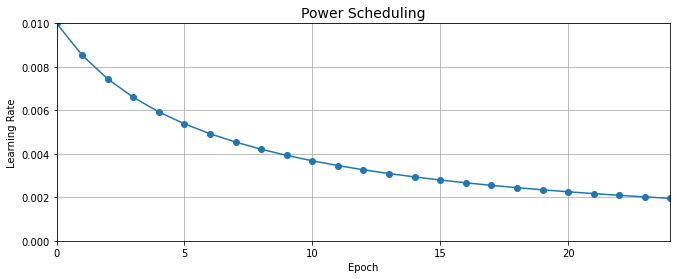

In [28]:
import numpy as np
import matplotlib.pyplot as plt

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.figure(figsize=(11, 4))
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### Exponential scheduling

Set the learning rate to: $\eta(t)=\eta_0 (0.1)^{\frac{t}{s}}$. The learning rate will gradually drop by a factor of $10$ every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of $10$ every $s$ steps.

Implementing Exponential scheduling is quite simple too. You first need to define a function that takes the current epoch and returns the learning rate.

In [29]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

If you do not want to hard-code $\eta_0$ and $s$, you can create a function that returns a configured function:

In [30]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

Next, just create a `LearningRateScheduler` callback, giving it the schedule function, and pass this callback to the `fit()` method:

In [32]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 140us/step - loss: 0.8347 - accuracy: 0.7621 - val_loss: 0.7131 - val_accuracy: 0.7830
Epoch 2/25
55000/55000 [==============================] - 8s 139us/step - loss: 0.6670 - accuracy: 0.7983 - val_loss: 0.7745 - val_accuracy: 0.8052
Epoch 3/25
55000/55000 [==============================] - 8s 139us/step - loss: 0.6176 - accuracy: 0.8168 - val_loss: 0.7733 - val_accuracy: 0.8038
Epoch 4/25
55000/55000 [==============================] - 8s 139us/step - loss: 0.5166 - accuracy: 0.8397 - val_loss: 0.5539 - val_accuracy: 0.8356
Epoch 5/25
55000/55000 [==============================] - 8s 138us/step - loss: 0.4902 - accuracy: 0.8489 - val_loss: 0.6190 - val_accuracy: 0.8166
Epoch 6/25
55000/55000 [==============================] - 8s 138us/step - loss: 0.4413 - accuracy: 0.8586 - val_loss: 0.5042 - val_accuracy: 0.8548
Epoch 7/25
55000/55000 [==============================] - 8s 13

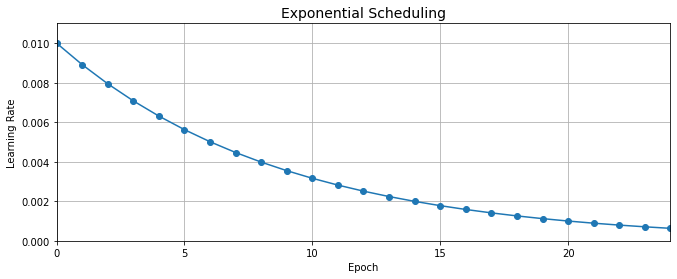

In [33]:
#@title
plt.figure(figsize=(11, 4))
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The `LearningRateScheduler` will update the optimizer’s `learning_rate` attribute at the beginning of each epoch. Updating the learning rate just once per epoch is usually enough, but if you want it to be updated more often, for example at every step, you need to write your own callback. This can make sense if there are many steps per epoch.



In [34]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 9s 171us/step - loss: 0.8615 - accuracy: 0.7556 - val_loss: 0.8354 - val_accuracy: 0.7950
Epoch 2/25
55000/55000 [==============================] - 9s 166us/step - loss: 0.6598 - accuracy: 0.7960 - val_loss: 0.5924 - val_accuracy: 0.8348
Epoch 3/25
55000/55000 [==============================] - 9s 166us/step - loss: 0.5719 - accuracy: 0.8227 - val_loss: 0.5188 - val_accuracy: 0.8486
Epoch 4/25
55000/55000 [==============================] - 9s 165us/step - loss: 0.5284 - accuracy: 0.8381 - val_loss: 0.4740 - val_accuracy: 0.8516
Epoch 5/25
55000/55000 [==============================] - 9s 168us/step - loss: 0.4618 - accuracy: 0.8503 - val_loss: 0.5180 - val_accuracy: 0.8436
Epoch 6/25
55000/55000 [==============================] - 10s 177us/step - loss: 0.4339 - accuracy: 0.8596 - val_loss: 0.5001 - val_accuracy: 0.8522
Epoch 7/25
55000/55000 [==============================] - 9s 1

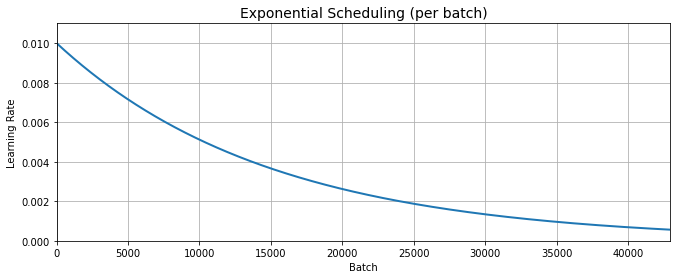

In [35]:
#@title
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.figure(figsize=(11, 4))
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function just multiplies the previous learning rate by $(0.1)^{\frac{1}{20}}$ , which results in the same exponential decay (except the decay now starts at the beginning of epoch $0$ instead of $1$). This implementation relies on the optimizer’s initial learning rate (contrary to the previous implementation), so make sure to set it appropriately.

In [36]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

When you save a model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, you could just load a trained model and continue training where it left off, no problem. However, things are not so simple if your schedule function uses the epoch argument: indeed, the epoch does not get saved, and it gets reset to 0 every time you call the `fit()` method. This could lead to a very large learning rate when you continue training a model where it left off, which would likely damage your model’s weights. One solution is to manually set the `fit()` method’s `initial_epoch` argument so the epoch starts at the right value.

#### Piecewise constant scheduling

Use a constant learning rate for a number of epochs (e.g., $\eta_0=0.1$ for $5$ epochs), then a smaller learning rate for another number of epochs (e.g., $\eta_1=0.001$ for $50$ epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates, and how long to use each of them.

In [37]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

As earlier, you can define a more general function if you want.

In [38]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [39]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 8s 140us/step - loss: 0.8723 - accuracy: 0.7513 - val_loss: 0.8916 - val_accuracy: 0.7376
Epoch 2/25
55000/55000 [==============================] - 8s 139us/step - loss: 0.8457 - accuracy: 0.7602 - val_loss: 0.7912 - val_accuracy: 0.7562
Epoch 3/25
55000/55000 [==============================] - 8s 138us/step - loss: 0.8760 - accuracy: 0.7515 - val_loss: 0.9102 - val_accuracy: 0.7078
Epoch 4/25
55000/55000 [==============================] - 8s 138us/step - loss: 0.9444 - accuracy: 0.7077 - val_loss: 0.8747 - val_accuracy: 0.7172
Epoch 5/25
55000/55000 [==============================] - 8s 144us/step - loss: 0.9498 - accuracy: 0.6713 - val_loss: 1.3946 - val_accuracy: 0.6278
Epoch 6/25
55000/55000 [==============================] - 8s 138us/step - loss: 0.7378 - accuracy: 0.7180 - val_loss: 0.7597 - val_accuracy: 0.7216
Epoch 7/25
55000/55000 [==============================] - 8s 13

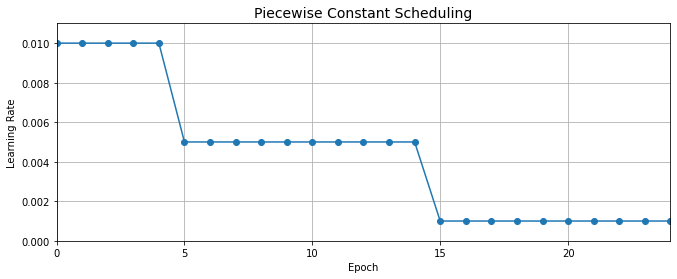

In [40]:
#@title
plt.figure(figsize=(11, 4))
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### Performance scheduling

Measure the validation error every $N$ steps (just like for early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

To implement performance scheduling simply use the `ReduceLROnPlateau` callback. For example, if you pass the following callback to the `fit()` method, it will multiply the learning rate by $0.5$ whenever the best validation loss does not improve for $5$ consecutive epochs (other options are available, please check the documentation for more details):

In [41]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 105us/step - loss: 0.5974 - accuracy: 0.8052 - val_loss: 0.4829 - val_accuracy: 0.8450
Epoch 2/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.5126 - accuracy: 0.8359 - val_loss: 0.5347 - val_accuracy: 0.8442
Epoch 3/25
55000/55000 [==============================] - 6s 101us/step - loss: 0.5098 - accuracy: 0.8442 - val_loss: 0.4879 - val_accuracy: 0.8436
Epoch 4/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.5185 - accuracy: 0.8444 - val_loss: 0.6734 - val_accuracy: 0.8224
Epoch 5/25
55000/55000 [==============================] - 6s 102us/step - loss: 0.5468 - accuracy: 0.8447 - val_loss: 0.5608 - val_accuracy: 0.8478
Epoch 6/25
55000/55000 [==============================] - 6s 101us/step - loss: 0.5364 - accuracy: 0.8500 - val_loss: 0.8003 - val_accuracy: 0.8378
Epoch 7/25
55000/55000 [==============================] - 6s 10

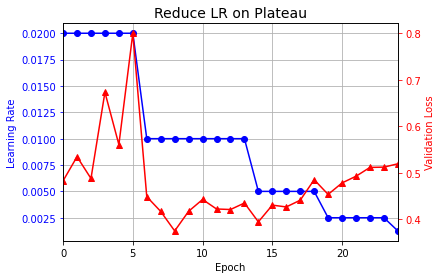

In [42]:
#@title
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

#### TensorFlow implementatiom

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: just define the learning rate using one of the schedules available in `keras.optimizers.schedules`, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as earlier:

In [43]:
import tensorflow as tf
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 95us/step - loss: 0.4879 - accuracy: 0.8289 - val_loss: 0.4086 - val_accuracy: 0.8594
Epoch 2/25
55000/55000 [==============================] - 5s 97us/step - loss: 0.3790 - accuracy: 0.8668 - val_loss: 0.3767 - val_accuracy: 0.8658
Epoch 3/25
55000/55000 [==============================] - 5s 98us/step - loss: 0.3467 - accuracy: 0.8765 - val_loss: 0.3582 - val_accuracy: 0.8722
Epoch 4/25
55000/55000 [==============================] - 5s 94us/step - loss: 0.3232 - accuracy: 0.8851 - val_loss: 0.3518 - val_accuracy: 0.8752
Epoch 5/25
55000/55000 [==============================] - 5s 94us/step - loss: 0.3067 - accuracy: 0.8903 - val_loss: 0.3403 - val_accuracy: 0.8814
Epoch 6/25
55000/55000 [==============================] - 5s 94us/step - loss: 0.2939 - accuracy: 0.8950 - val_loss: 0.3399 - val_accuracy: 0.8806
Epoch 7/25
55000/55000 [==============================] - 5s 93us/ste

For piecewise constant scheduling, try this:

In [44]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

This is nice and simple, plus when you save the model, the learning rate and its schedule (including its state) get saved as well. However, this approach is not part of the Keras API, it is specific to tf.keras.


To sum up, exponential decay or performance scheduling can considerably speed up convergence.

# Resources

- https://github.com/ageron/handson-ml2


- https://ruder.io/optimizing-gradient-descent/index.html#visualizationofalgorithms



- https://stackoverflow.com/questions/36162180/gradient-descent-vs-adagrad-vs-momentum-in-tensorflow